In [191]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFECV

scaler = StandardScaler()

In [192]:
bike = pd.read_csv('bike.csv')
bike.head()

,Unnamed: 0,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,0,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,985
1,1,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,801
2,2,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,1349
3,3,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,1562
4,4,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,1600


In [193]:
X = bike.iloc[:, 1:11]
feature_cols = ['season', 'yr', 'mnth', 'holiday','weekday','workingday','weathersit', 'temp', 'hum', 'windspeed']
Y = bike.iloc[:, 11]
y_label = np.where(Y > 4500, 1, 0)
X_scaled = scaler.fit_transform(X)

In [194]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

rental_bins = pd.qcut(Y, 
                      q = 3, 
                      labels = ['low', 'medium', 'high'])

In [195]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, 
                                                    rental_bins, 
                                                    test_size = 0.2, 
                                                    random_state = 42)
X_trainDF = pd.DataFrame(X_train)
X_trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       584 non-null    float64
 1   1       584 non-null    float64
 2   2       584 non-null    float64
 3   3       584 non-null    float64
 4   4       584 non-null    float64
 5   5       584 non-null    float64
 6   6       584 non-null    float64
 7   7       584 non-null    float64
 8   8       584 non-null    float64
 9   9       584 non-null    float64
dtypes: float64(10)
memory usage: 45.8 KB


In [196]:
clf = DecisionTreeClassifier(max_depth = 25, 
                             min_samples_split = 20, 
                             min_samples_leaf = 25)

clf = clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

In [197]:
print("Accuracy:", 
      metrics.accuracy_score(Y_test, Y_pred))

Accuracy: 0.7210884353741497


In [198]:
text_representation = tree.export_text(clf)
print(text_representation)

|--- feature_4 <= -0.04
|   |--- feature_0 <= 0.61
|   |   |--- feature_6 <= 0.45
|   |   |   |--- feature_4 <= -0.46
|   |   |   |   |--- feature_2 <= -0.24
|   |   |   |   |   |--- feature_5 <= -0.33
|   |   |   |   |   |   |--- class: medium
|   |   |   |   |   |--- feature_5 >  -0.33
|   |   |   |   |   |   |--- class: medium
|   |   |   |   |--- feature_2 >  -0.24
|   |   |   |   |   |--- class: medium
|   |   |   |--- feature_4 >  -0.46
|   |   |   |   |--- class: low
|   |   |--- feature_6 >  0.45
|   |   |   |--- class: low
|   |--- feature_0 >  0.61
|   |   |--- feature_6 <= -0.08
|   |   |   |--- class: low
|   |   |--- feature_6 >  -0.08
|   |   |   |--- class: low
|--- feature_4 >  -0.04
|   |--- feature_1 <= 0.96
|   |   |--- feature_0 <= 1.79
|   |   |   |--- feature_2 <= 0.21
|   |   |   |   |--- feature_6 <= 0.72
|   |   |   |   |   |--- feature_3 <= 0.12
|   |   |   |   |   |   |--- class: high
|   |   |   |   |   |--- feature_3 >  0.12
|   |   |   |   |   |   |--- cla

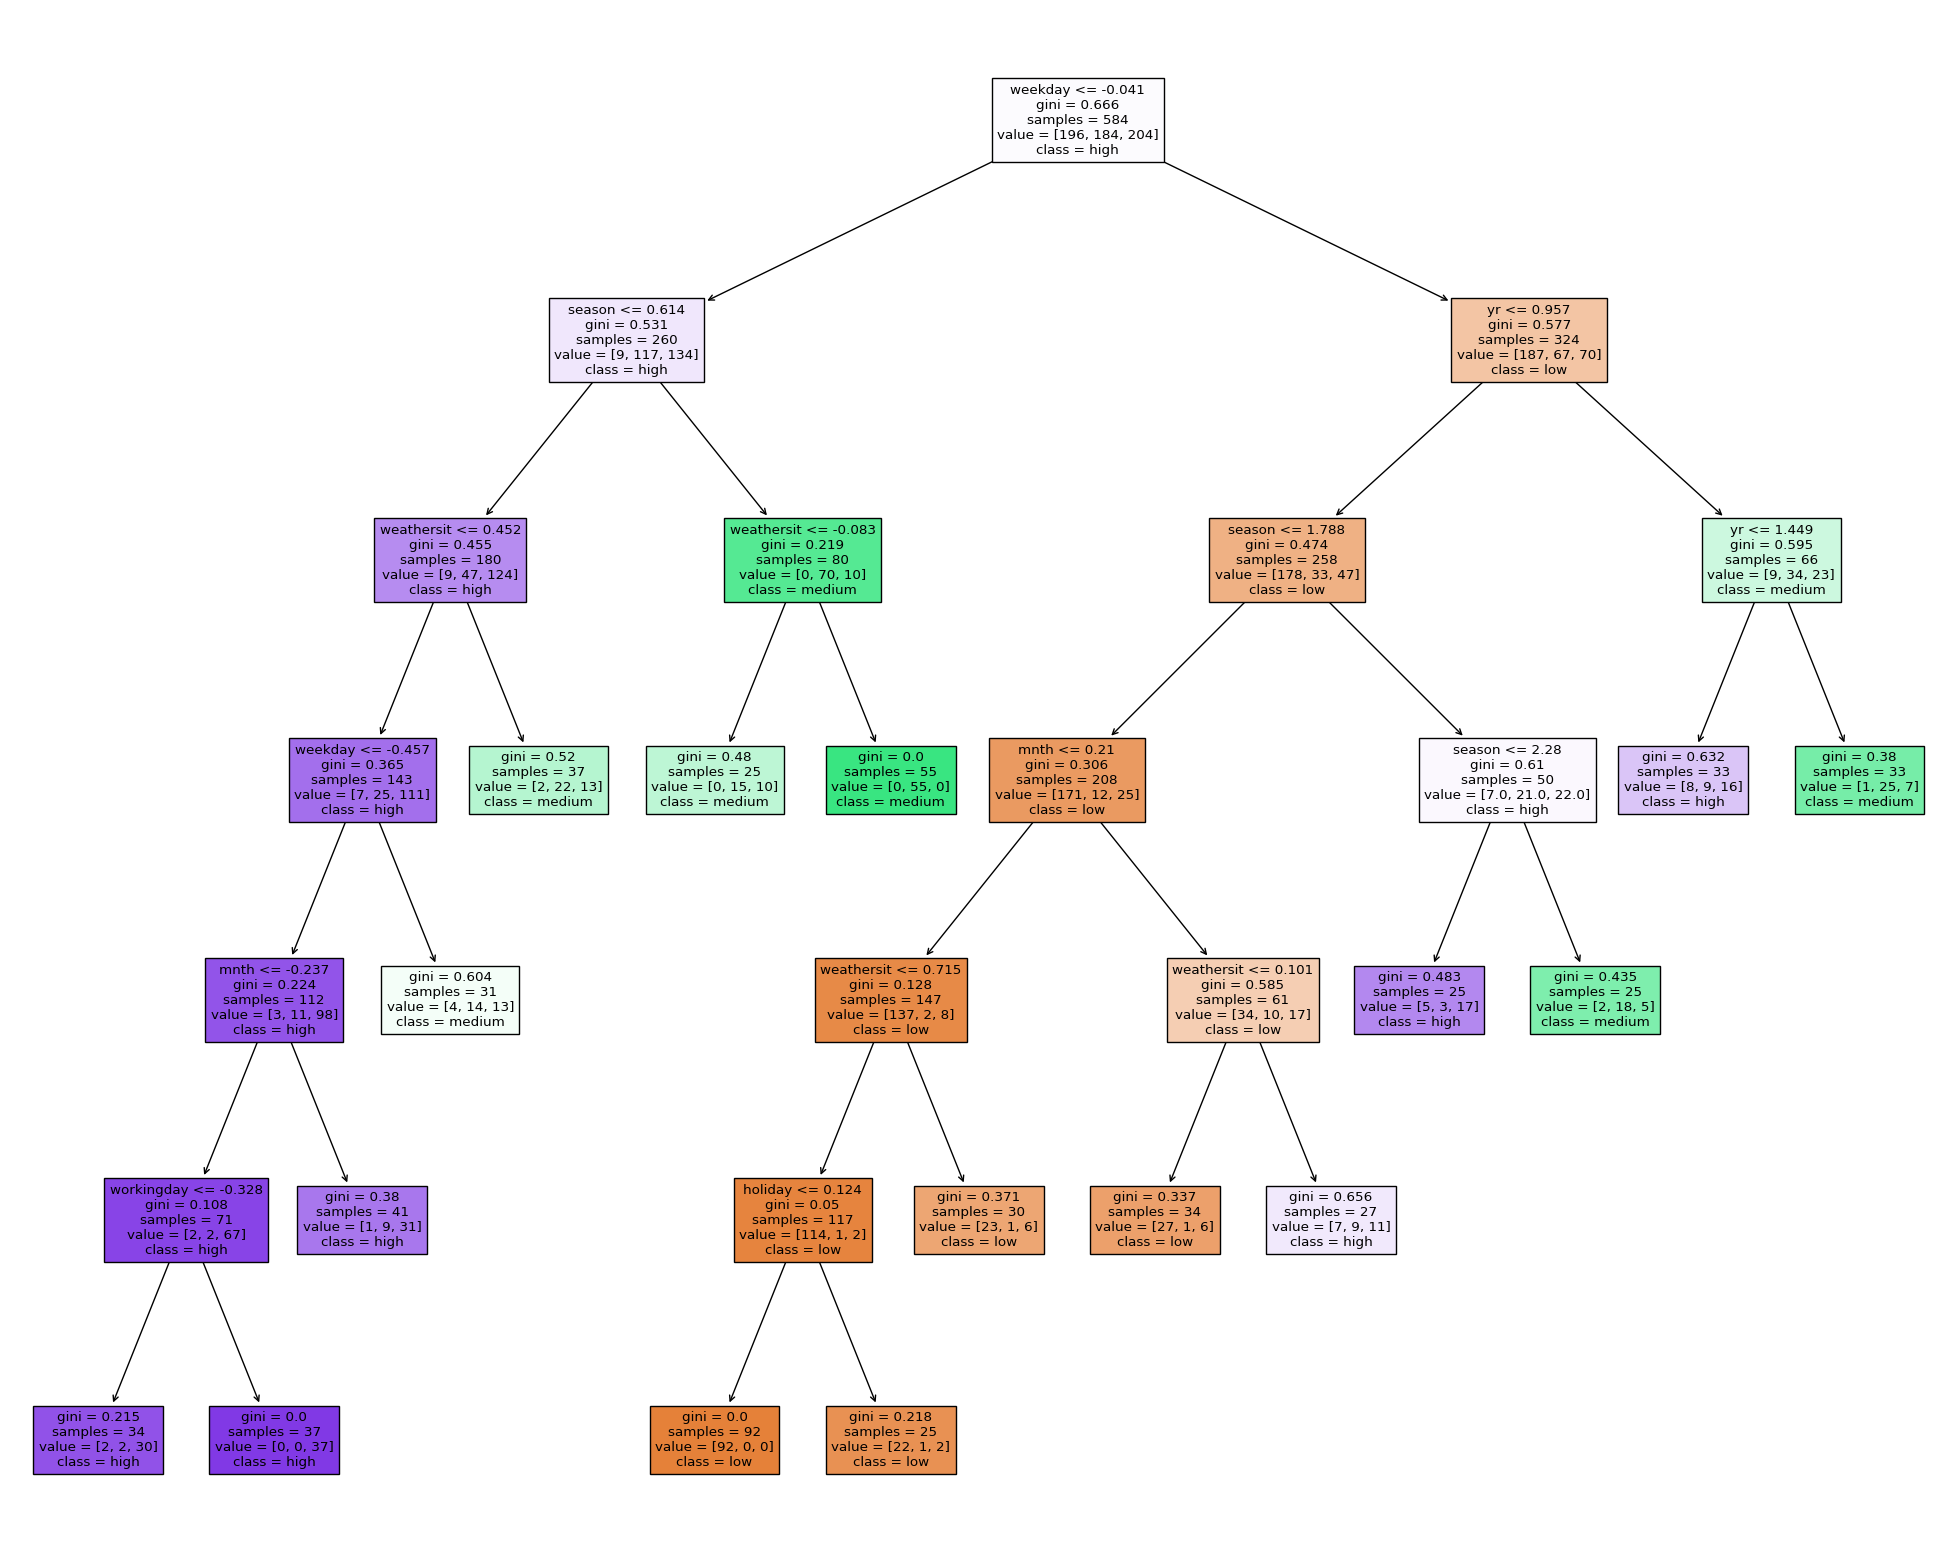

In [199]:
fig = plt.figure(figsize = (25,20))
_ = tree.plot_tree(clf, 
                   feature_names = feature_cols,  
                   class_names = ['low', 'medium', 'high'],
                   filled = True)

In [200]:
pipeline = Pipeline([
    ('feature_selection', 
     RFE(estimator = DecisionTreeClassifier())),
    ('classification', 
     DecisionTreeClassifier())
])

In [201]:
param_grid = {
    'feature_selection__n_features_to_select': [5, 10, 15],  
    'classification__max_depth': [None, 10, 20], 
    'classification__min_samples_split': [2, 5, 10],
    'classification__min_samples_leaf': [1, 2, 4]
}

In [202]:
grid_search = GridSearchCV(pipeline, 
                           param_grid, 
                           cv = 5, 
                           scoring = 'accuracy')
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selection',
                                        RFE(estimator=DecisionTreeClassifier())),
                                       ('classification',
                                        DecisionTreeClassifier())]),
             param_grid={'classification__max_depth': [None, 10, 20],
                         'classification__min_samples_leaf': [1, 2, 4],
                         'classification__min_samples_split': [2, 5, 10],
                         'feature_selection__n_features_to_select': [5, 10,
                                                                     15]},
             scoring='accuracy')

In [203]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:")
print(best_params)

Best Parameters:
{'classification__max_depth': None, 'classification__min_samples_leaf': 2, 'classification__min_samples_split': 10, 'feature_selection__n_features_to_select': 5}


In [204]:
test_accuracy = best_model.score(X_test, Y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.782312925170068


In [205]:
f1_macro = f1_score(Y_test, Y_pred, average='macro')

print("F1 score (macro):", f1_macro)

F1 score (macro): 0.7022788153178645


In [206]:
Y_pred = best_model.predict(X_test)

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

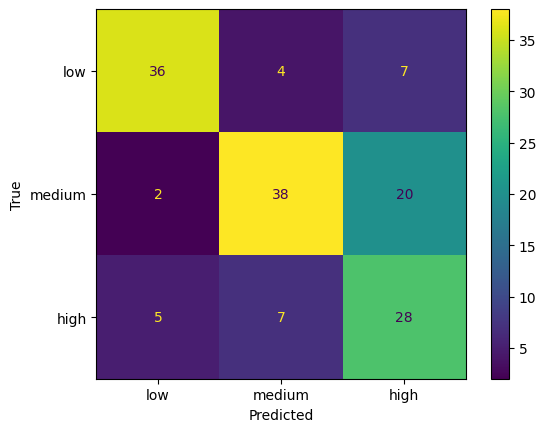

In [207]:
dtc = DecisionTreeClassifier()

selector = SFS(dtc)

selector.fit(X_train, Y_train)

X_train_dtc = selector.transform(X_train)
X_test_dtc = selector.transform(X_test)

dtc.fit(X_train_dtc, Y_train)
Y_pred = dtc.predict(X_test_dtc) 

cf_matrix = confusion_matrix(Y_test,Y_pred)

cmd = ConfusionMatrixDisplay(cf_matrix, display_labels = ['low', 'medium', 'high'])
cmd.plot()
cmd.ax_.set(xlabel = 'Predicted', ylabel = 'True')

In [208]:
features = selector.fit_transform(X_train, Y_train) 

feature_idx = selector.get_support(indices = True)

feature_names = X_train.columns[feature_idx]

features = pd.DataFrame(features, columns = feature_names)
features.head()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

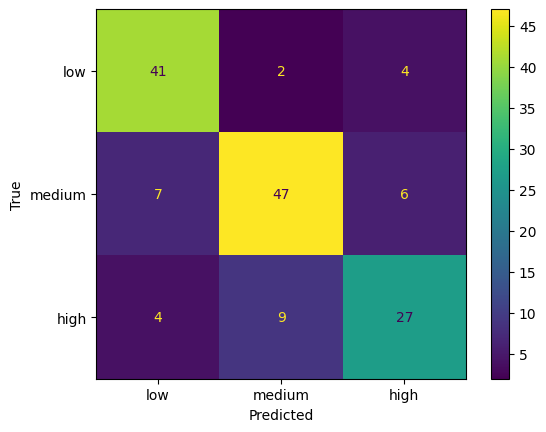

In [ ]:
selector = RFECV(dtc, cv = 2) 
selector.fit(X_train, Y_train)

X_train_rfe = selector.transform(X_train)
X_test_rfe = selector.transform(X_test)


dtc.fit(X_train_rfe, Y_train)
Y_pred = dtc.predict(X_test_rfe) 

cf_matrix = confusion_matrix(Y_test, Y_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels = ['low', 'medium', 'high'])
cmd.plot()
cmd.ax_.set(xlabel = 'Predicted', ylabel = 'True')

In [ ]:
features = selector.fit_transform(X_train, Y_train) 

feature_idx = selector.get_support(indices = True)

feature_names = X_train.columns[feature_idx]

features = pd.DataFrame(features, columns = feature_names)
